See also [Indicator Sampling section](https://exhbma.readthedocs.io/en/latest/index.html) in the documentation.

In [1]:
import logging

import numpy as np

import sys

sys.path.append("../")
from exhbma import (
    StandardScaler,
    feature_posterior,
)
from exhbma.sampling import IndicatorSampling, InversePrior
from exhbma.plot_utils import (
    plot_sampling_autocorrelation,
    plot_sampling_sequence,
    plot_two_parameter_trajectory
)

In [2]:
log_level = logging.INFO
logger = logging.getLogger(__name__)
logger.propagate = False
handler = logging.StreamHandler()
handler_format = logging.Formatter(
    fmt="%(levelname)s %(asctime)s [%(name)s]: %(message)s",
    datefmt="%Y-%m-%dT%H:%M:%S%z",
)
handler.setFormatter(handler_format)
handler.setLevel(log_level)
logger.setLevel(log_level)
logger.addHandler(handler)

# Generate sample dataset

In [3]:
n_data, n_features = 50, 30
sigma_noise = 0.1

nonzero_w = [1, -0.75, 0.5, -0.25]
w = nonzero_w + [0] * (n_features - len(nonzero_w))

np.random.seed(0)
X = np.random.randn(n_data, n_features)
y = np.dot(X, w) + sigma_noise * np.random.randn(n_data)

# Train a model by sampling

In [4]:
# Data preprocessing
x_scaler = StandardScaler(n_dim=2)
y_scaler = StandardScaler(n_dim=1, scaling=False)
x_scaler.fit(X)
y_scaler.fit(y)
X = x_scaler.transform(X)
y = y_scaler.transform(y)

In [5]:
sampler = IndicatorSampling(
    X=X,
    y=y,
    sigma_noise_prior=InversePrior(low=10**-3, high=10**2),
    sigma_coef_prior=InversePrior(low=10**-3, high=10**2),
)

sampler.sample(
    n_burn_in=10**4,
    n_sampling=10**4,
    random_state=0,
    exact_calc_interval=100,
)

  1%|          | 124/10000 [00:00<00:32, 305.45it/s]/Users/obi-macmini/Dropbox/Laboratory/exhbma/tutorials/../exhbma/sampling/indicator_sampling.py:223: RuntimeWarning: divide by zero encountered in log
  post += np.log(self.sigma_noise_prior.prob(new_sv.sigma_noise))
100%|██████████| 10000/10000 [00:31<00:00, 320.62it/s]


# Results

## Feature posterior

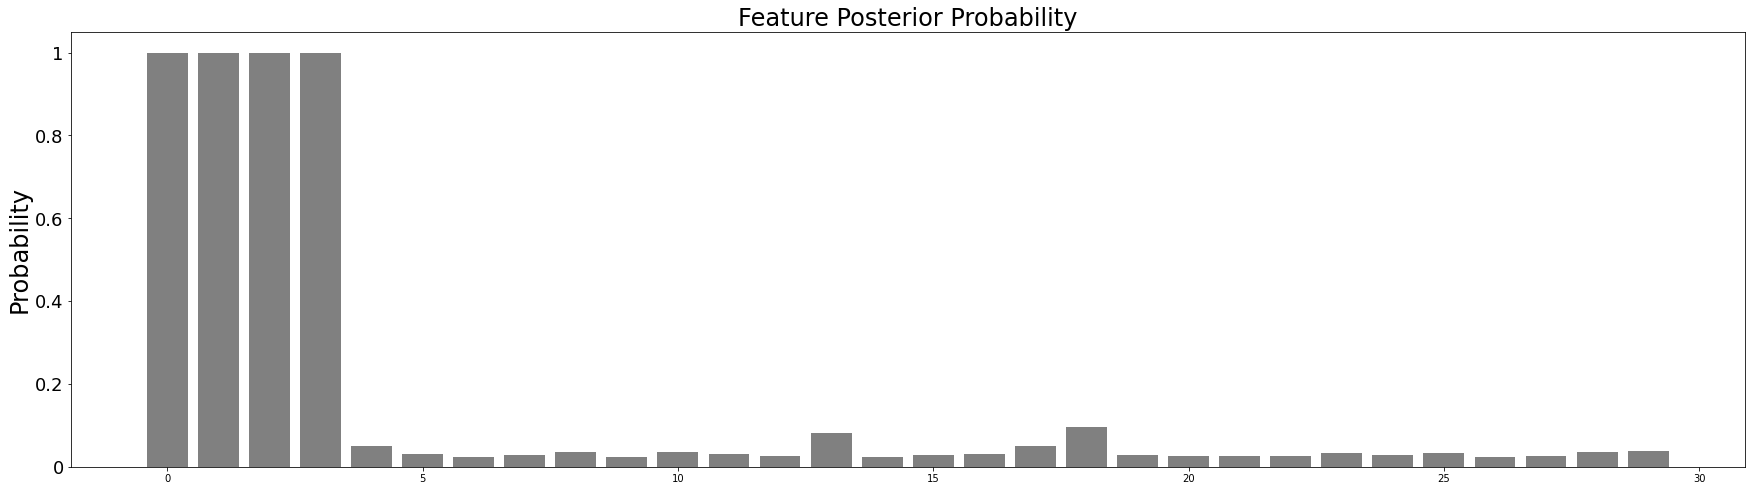

In [6]:
fig, ax = feature_posterior(
       model=sampler,
       title="Feature Posterior Probability",
       ylabel="Probability",
   )

# Prediction

In [7]:
n_test = 10**3

np.random.seed(10)
test_X = np.random.randn(n_test, n_features)
test_y = np.dot(test_X, w) + sigma_noise * np.random.randn(n_test)

## Linear model using features selected by posteriors

In [8]:
from exhbma import MarginalLinearRegression, inverse

In [9]:
threshold = 0.5

index = np.array(sampler.feature_posteriors_) >= threshold
X_ext = X[:, index]

reg = MarginalLinearRegression(
    sigma_noise_points=inverse(
        np.logspace(-3, 2, 41),
    ),
    sigma_coef_points=inverse(
        np.logspace(-3, 2, 41),
    ),
)
reg.fit(X_ext, y)

## RMSE for test data

In [10]:
pred_y = y_scaler.restore(
    reg.predict(x_scaler.transform(test_X)[:, index])
)
rmse = np.power(test_y - pred_y, 2).mean() ** 0.5
logger.info(f"RMSE for test data: {rmse:.4f}")

INFO 2022-08-09T17:45:58+0900 [__main__]: RMSE for test data: 0.1037


# Advanced Topics

In [11]:
from matplotlib import pyplot as plt
from matplotlib import gridspec

## $\sigma_{\text{noise}}$ and $\sigma_{\text{coef}}$ sampling sequence

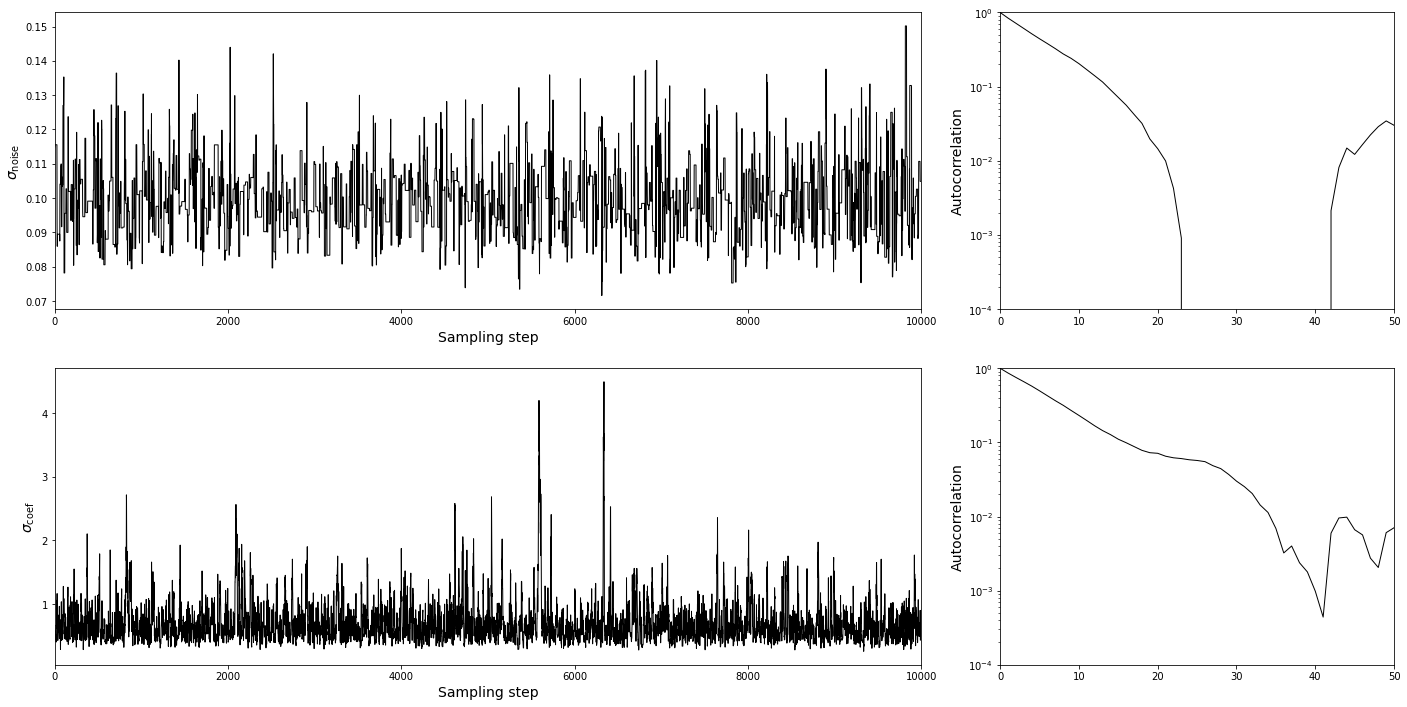

In [12]:
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(2, 3)

for i, param in enumerate(["noise", "coef"]):
    ax1 = fig.add_subplot(gs[i, :2])
    ax2 = fig.add_subplot(gs[i, 2:])
    
    seq = getattr(sampler, f"sigma_{param}_sequence_")

    ax1 = plot_sampling_sequence(
        seq=seq,
        ax=ax1,
        ylabel=f"$\sigma_{{\mathdefault{{{param}}}}}$",
        xlabel="Sampling step",
    )

    ax2 = plot_sampling_autocorrelation(
        seq=seq,
        ax=ax2,
        ylabel="Autocorrelation",
        xlim=[0, 50],
        ylim=[1e-4, 1],
    )

## Sampling sequence trajectory (posterior distribution)

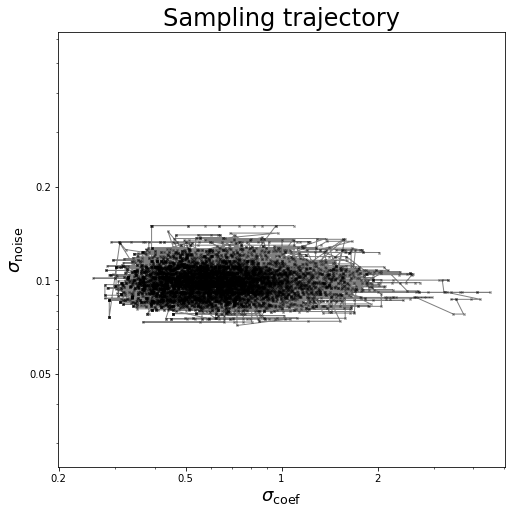

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax = plot_two_parameter_trajectory(
    seq1=sampler.sigma_coef_sequence_,
    seq2=sampler.sigma_noise_sequence_,
    ax=ax,
    xlim=[10**-0.7, 10**0.7],
    ylim=[10**-1.6, 10**-0.2],
    xticks=[0.2, 0.5, 1, 2],
    yticks=[0.05, 0.1, 0.2],
    xlabel="$\sigma_{\mathdefault{coef}}$",
    ylabel="$\sigma_{\mathdefault{noise}}$",
    title="Sampling trajectory",
)